# Contour Monte Carlo
This Julia notebook demonstrates how to perform Contour Monte Carlo to invert the Michaelis-Menten equation. Note that the code uses the `RCall` Julia package to call R, in order to use the vine copula kernel density estimation available in the R package `kdevine`.

In [1]:
using RCall, Compat, Random, Distributions, Plots, DifferentialEquations

R"library(kdevine)"

function f_solve(f_deriv, initial, tspan, parameters)
    prob = ODEProblem(f_deriv, initial, tspan, parameters)
    sol = solve(prob)
    return sol
end

function f_sample_solve_uniform(num_samples, population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial)
    n_params = size(bounds)[1]
    samples = zeros((num_samples, n_params))
    for i = 1:n_params
        samples[:, i] = rand(Uniform(bounds[i, 1], bounds[i, 2]), num_samples)
    end
    mOutputs = zeros((num_samples, length(population_sample)))
    for i in 1:num_samples
        sol = f_solve(f_deriv, initial, tspan, samples[i, :]);
        for j = 1:length(population_sample)
           mOutputs[i, j] = sol(times_solve[j], idxs=population_sample[j])
        end
    end
    return mOutputs
end

function f_estimate_kdevine(mOutputs)
    @rput mOutputs
    R"fit <- kdevine(mOutputs)"
end

function dkdevine(params)
    @rput params
    R"z <- dkdevine(params, fit)"
    @rget z
    return z
end

function f_step_bounds(vCurrent, bounds, sigma)
    vProposed = zeros(size(bounds)[1])
    for i = 1:length(vProposed)
        temp = (rand(Normal(vCurrent[i] - bounds[i, 1], sigma[i]), 1)[1] % (bounds[i, 2] - bounds[i, 1]))
        if temp < 0
            temp += bounds[i, 2]
        else
            temp += bounds[i, 1]
        end
        vProposed[i] = temp
    end
    return vProposed
end

function f_mcmc_uniform(num_samples, dist_target, f_dkdevine, sigma, population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial)
    mInputs = zeros((num_samples, size(bounds)[1]))
    mOutputs = zeros((num_samples, length(population_sample)))
    vOutputs_temp = zeros(length(population_sample))
    # initial points
    mInputs[1, :] = f_step_bounds(mean(bounds, dims=2), bounds, sigma)
    for j = 1:length(population_sample)
        sol = f_solve(f_deriv, initial, tspan, mInputs[1, :]);
        mOutputs[1, j] = sol(times_solve[j], idxs=population_sample[j])
    end
    log_pdf_current = logpdf(dist_target, mOutputs[1, :])
    log_contour_current = log(f_dkdevine(mOutputs[1, :]))
    # MCMC
    for i = 2:num_samples
        vProposed = f_step_bounds(mInputs[i - 1, :], bounds, sigma)
        sol = f_solve(f_deriv, initial, tspan, vProposed);
        for j = 1:length(population_sample)
            vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
        end
        log_pdf_proposed = logpdf(dist_target, vOutputs_temp)
        log_contour_proposed = log(f_dkdevine(vOutputs_temp))
        log_r = ((log_pdf_proposed + log_contour_current) -
                 (log_pdf_current + log_contour_proposed))
        if log_r > log(rand(Uniform(), 1)[1])
            mInputs[i, :] = vProposed
            mOutputs[i, :] = vOutputs_temp
            log_pdf_current = log_pdf_proposed
            log_contour_current = log_contour_proposed
        else
            mInputs[i, :] = mInputs[i - 1, :]
            mOutputs[i, :] = mOutputs[i - 1, :]
        end
    end
    return Dict("inputs" => mInputs, "outputs" => mOutputs)
end


R version 3.4.2 (2017-09-28) -- "Short Summer"
Copyright (C) 2017 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.



┌ Warning: RCall.jl: Warning: package 'kdevine' was built under R version 3.4.4
│ The kdevine package is no longer actively developed. Consider using 
│    - the 'kde1d' package for marginal estimation, 
│    - the functions vine() and vinecop() from the 'rvinecopulib' 
│      package as replacements for kdevine() and kdevincop().
└ @ RCall C:\Users\bclamber\.julia\packages\RCall\ffM0W\src\io.jl:113


f_mcmc_uniform (generic function with 1 method)

## Michaelis-Menten kinetics

First estimate volume of contours.

In [111]:
function deriv_michaelis_menten(dydt, y, p, t)
    k_f = p[1]
    k_r = p[2]
    k_cat = p[3]
    dydt[1] = -k_f * y[1] * y[2] + k_r * y[3] + k_cat * y[3]
    dydt[2] = -k_f * y[1] * y[2] + k_r * y[3]
    dydt[3] = k_f * y[1] * y[2] - k_r * y[3] - k_cat * y[3]
    dydt[4] = k_cat * y[3]
end

mBounds = [[0.2 15]; [0.2 2]; [0.5 3]];

tspan = (0.0, 10.0)
initial = [4.0; 8.0; 0.0; 0.0];

mOutputs = @time f_sample_solve_uniform(10000, [1, 2], [2, 1], tspan, f_solve, deriv_michaelis_menten, mBounds, initial);

@time f_estimate_kdevine(mOutputs);

  5.152820 seconds (14.98 M allocations: 1.192 GiB, 6.16% gc time)
 10.681343 seconds (9.59 k allocations: 490.019 KiB)


Now do MCMC.

In [6]:
d = MvNormal([2.8, 1.0], [[0.02 -0.01]; [-0.01 0.02]]);
temp = @time f_mcmc_uniform(5000, d, dkdevine, [1, 0.1, 0.1], [1, 2], [2, 1], tspan, f_solve, deriv_michaelis_menten, mBounds, initial);

 65.132850 seconds (6.89 M allocations: 573.806 MiB, 0.27% gc time)


Plot the input distribution.

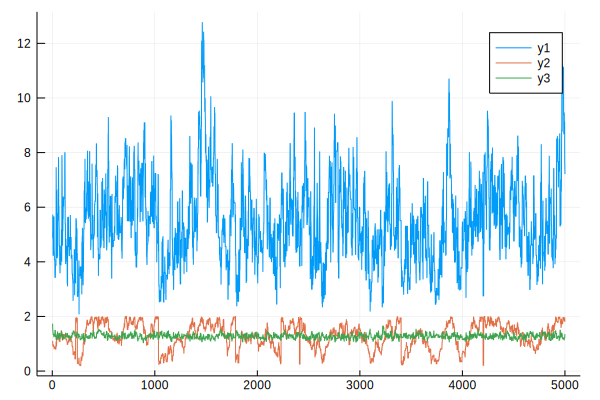

In [7]:
plot(temp["inputs"])

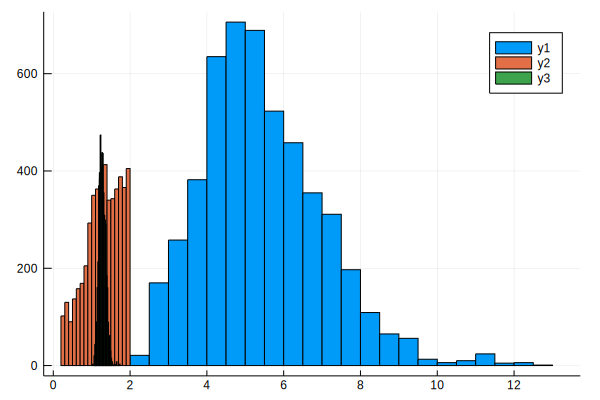

In [15]:
histogram(temp["inputs"])

Plot the output distributions.

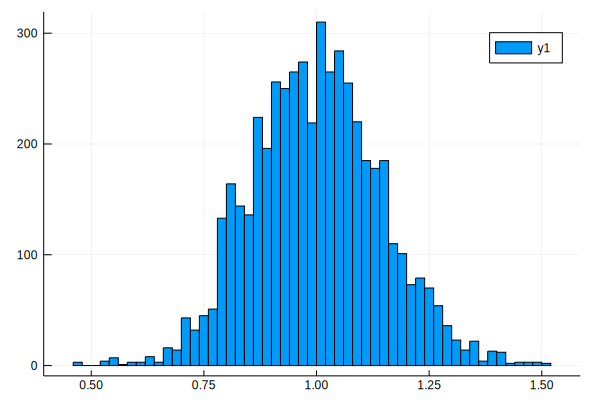

In [9]:
histogram(temp["outputs"][:, 2])

Check how close to $\mathcal{N}([2.8, 1.0], [[0.02, -0.01]; [-0.01, 0.02]])$ target.

In [16]:
println(cov(temp["outputs"]))
println(mean(temp["outputs"], dims=1))

[0.0213836 -0.0103285; -0.0103285 0.0204802]
[2.80375 0.999906]


## Target a bimodal distribution

Find distributions which are different to current.

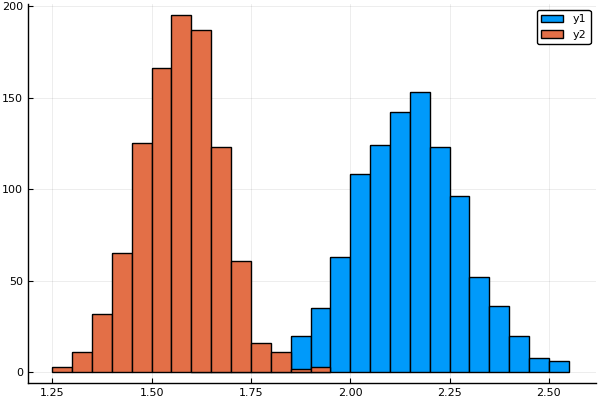

In [139]:
n = 1000
mOutputs = zeros((n, 2))
samples = rand(MvNormal([5, 1.5, 1.0], 0.05), n)
for i = 1:n
    sol = f_solve(deriv_michaelis_menten, [4.0; 8.0; 0.0; 0.0], tspan, samples[:, i]);
    mOutputs[i, :] = [sol(2, idxs=1), sol(1, idxs=2)]
end
histogram(mOutputs)

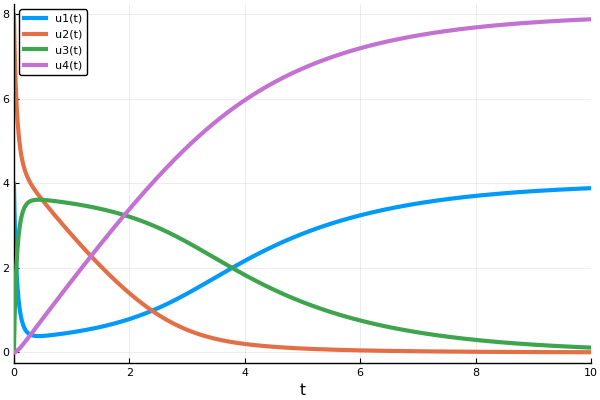

In [144]:
sol = f_solve(deriv_michaelis_menten, [4.0; 8.0; 0.0; 0.0], tspan, [2.5; 0.5; 0.5]);
plot(sol)

In [146]:
println(mean(mOutputs, dims=1))
cov(mOutputs)

[2.14583 1.57301]


2×2 Array{Float64,2}:
  0.0184311  -0.0134685
 -0.0134685   0.0101227

In [147]:
dist=MixtureModel(MvNormal[MvNormal([2.15, 1.6], [[0.0184 -0.013]; [-0.013 0.01]]),
        MvNormal([2.8, 1.0], [[0.02 -0.01]; [-0.01 0.02]])]);

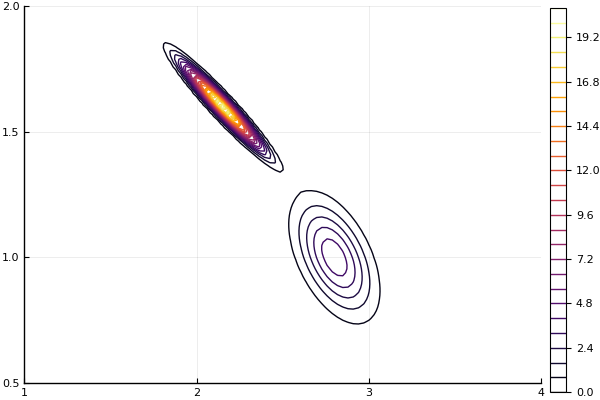

In [156]:
using Plots
pyplot()
V(x,y) = pdf(dist, [x, y])
x = range(1, 4, length=100)
y = range(0.5, 2, length=100)
contour(x, y, (x,y)->V(x,y), levels=30)

In [149]:
temp = @time f_mcmc_uniform(5000, dist, dkdevine, [1, 0.1, 0.1], [1, 2], [2, 1], tspan, f_solve, deriv_michaelis_menten, mBounds, initial);

 41.453871 seconds (7.19 M allocations: 581.016 MiB, 0.40% gc time)


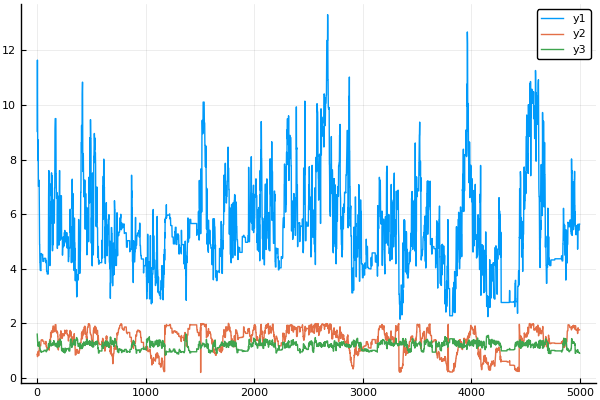

In [150]:
plot(temp["inputs"])

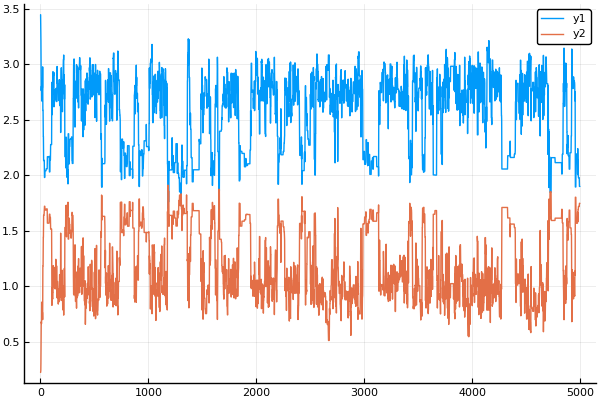

In [151]:
plot(temp["outputs"])

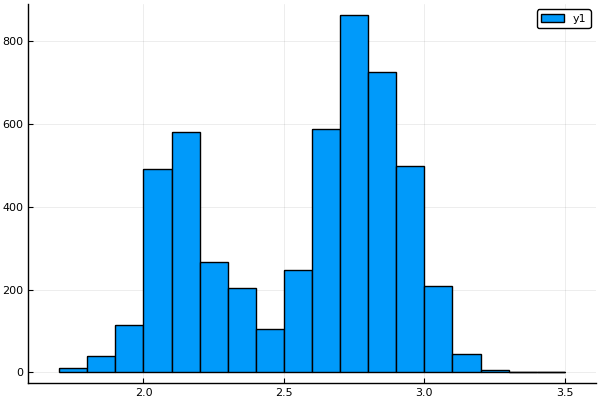

In [152]:
histogram(temp["outputs"][:, 1])

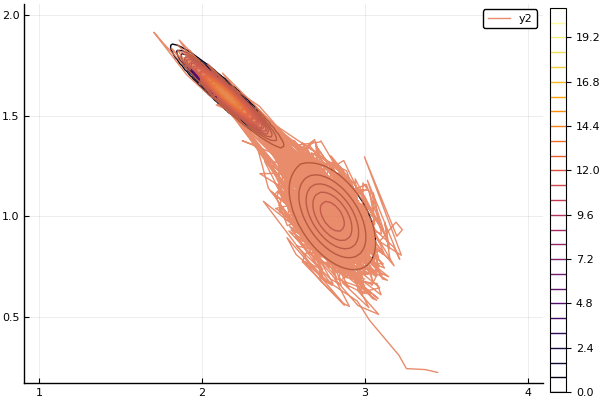

In [166]:
x = range(1, 4, length=100)
y = range(0.5, 2, length=100)
contour(x, y, (x,y)->V(x,y), levels=30);
plot!(temp["outputs"][:, 1], temp["outputs"][:, 2], alpha=0.8)

In [142]:
using KernelDensity
f = kde(mOutputs);

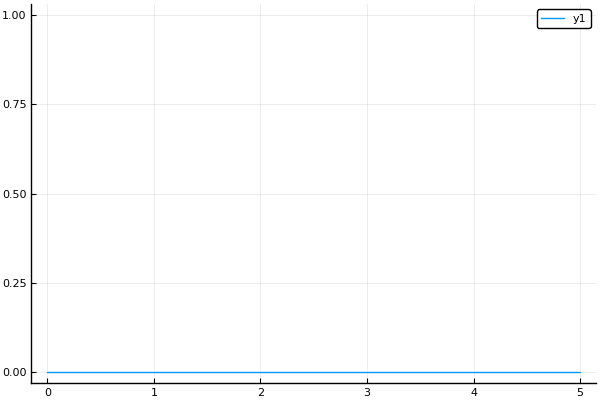

In [143]:
xx=collect(0:0.01:5)
plot(xx, map(x->pdf(f, x, 2.8), xx))

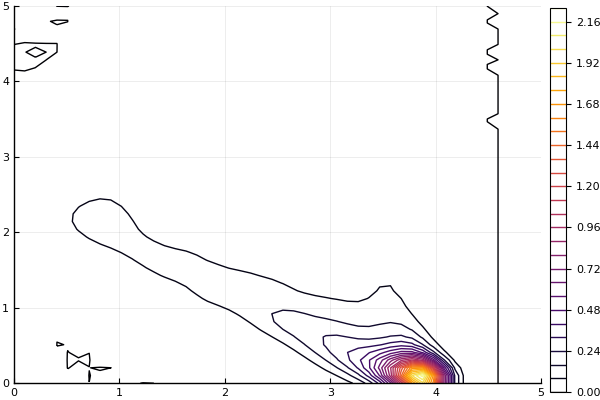

In [123]:
x = range(0, 5, length=50)
y = range(0, 5, length=50)
contour(x, y, (x, y)->pdf(f, x, y), levels=30)

## TNF signalling pathway

In [3]:
function inh(x, b)
    return b^2 / (x^2 + b^2)
end

function act(x, a)
    return x^2 / (a^2 + x^2)
end

function u(t)
    return 0.0
end

function deriv_tnf_signalling(dxdt, y, p, t)
    a1=p[1]; a2=p[2]; a3=p[3]; a4=p[4];
    b1=p[5]; b2=p[6]; b3=p[7]; b4=p[8]; b5=p[9];
    x1=y[1]; x2=y[2]; x3=y[3]; x4=y[4];
    dxdt[1] = -x1 + 0.5 * (inh(x3, b4) * act(u(t), a1) + act(x2, a3))
    dxdt[2] = -x2 + act(x1, a2) * inh(x3, b3)
    dxdt[3] = -x3 + inh(x2, b2) * inh(x4, b5)
    dxdt[4] = -x4 + 0.5 * (inh(u(t), b1) + act(x3, a4))
end

deriv_tnf_signalling (generic function with 1 method)

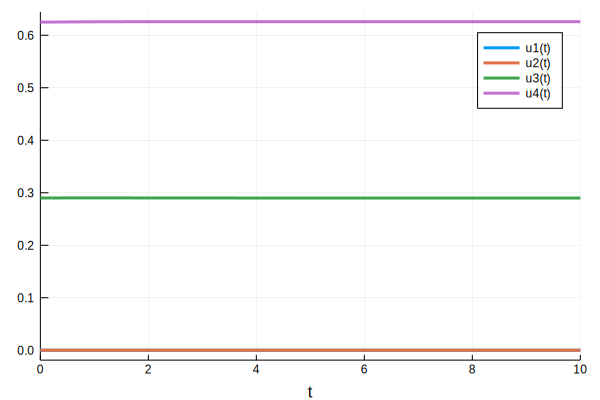

In [4]:
tspan = (0.0, 10.0)
sol = f_solve(deriv_tnf_signalling, [0.0; 0.0; 0.29; 0.625], tspan, [0.6; 0.2; 0.2; 0.5; 0.4; 0.7; 0.3; 0.5; 0.4]);
plot(sol)

Now add in $u(t) = 1$ when $t\in[0,2]$. 

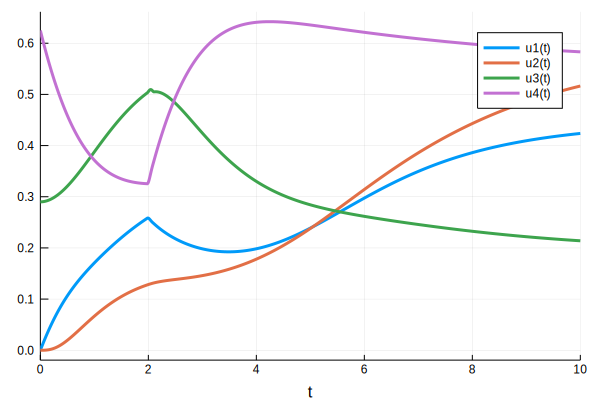

In [5]:
function u(t)
    if t < 2
        return 1.0
    else
        return 0.0
    end
end

b3 = 0.3
tspan = (0.0, 10.0)
sol = f_solve(deriv_tnf_signalling, [0.0; 0.0; 0.29; 0.625], tspan, [0.6; 0.2; 0.2; 0.5; 0.4; 0.7; b3; 0.5; 0.4]);
plot(sol)

Assume a bimodal distribution for b3 as a mixture of $\mathcal{N}(0.3, 0.02)$ and $\mathcal{N}(0.25, 0.02)$ and record data at $t=1, 4, 10$.

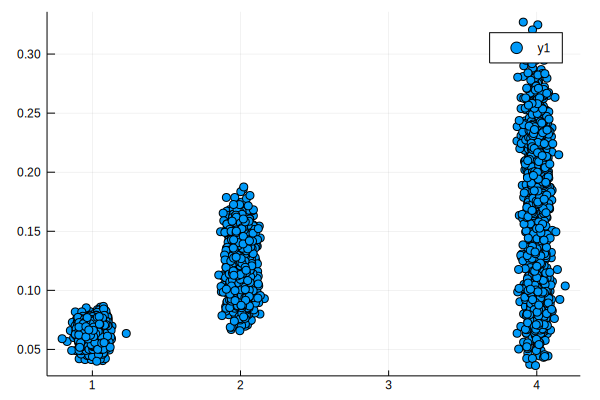

In [27]:
nsamples1 = 1000
mOutputs = zeros((nsamples1 * 3, 3))
vTimes = [1.0, 2.0, 4.0]
k = 1
for i = 1:nsamples1
    if rand(Uniform(), 1)[1] > 0.5
        b3 = rand(Normal(0.32, 0.02), 1)[1]
    else
        b3 = rand(Normal(0.26, 0.02), 1)[1]
    end
    sol = f_solve(deriv_tnf_signalling, [0.0; 0.0; 0.29; 0.625], tspan, [0.6; 0.2; 0.2; 0.5; 0.4; 0.7; b3; 0.5; 0.4]);
    for j = 1:3
        mOutputs[k, :] = [vTimes[j], vTimes[j] + rand(Normal(0, 0.05), 1)[1], sol(vTimes[j], idxs=2)]
        k += 1
    end
    
end

plot(mOutputs[:, 2], mOutputs[:, 3], seriestype=:scatter)

Target the distribution of observations at each time (roughly).

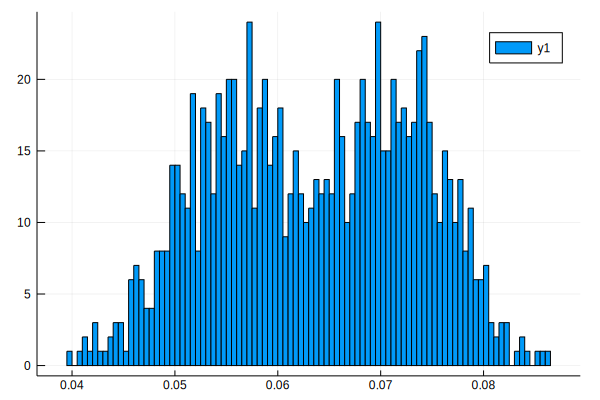

In [35]:
histogram(mOutputs[mOutputs[:, 1] .== 1, 3], bins=100)

In [36]:
function f_tnf_bimodal(v_values)
    dist_1 = Normal(0.06, 0.02);
    dist_2 = Normal(0.125, 0.05);
    dist_4 = MixtureModel([Normal(0.1, 0.02), Normal(0.23, 0.02)]);
    return f_log_pdf(v_values, [dist_1, dist_2, dist_4])
end

function f_mcmc_uniform_harder_target(num_samples, target_fn, f_dkdevine, sigma, population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial)
    mInputs = zeros((num_samples, size(bounds)[1]))
    mOutputs = zeros((num_samples, length(population_sample)))
    vOutputs_temp = zeros(length(population_sample))
    # initial points
    mInputs[1, :] = f_step_bounds(mean(bounds, dims=2), bounds, sigma)
    for j = 1:length(population_sample)
        sol = f_solve(f_deriv, initial, tspan, mInputs[1, :]);
        mOutputs[1, j] = sol(times_solve[j], idxs=population_sample[j])
    end
    log_pdf_current = target_fn(mOutputs[1, :])
    log_contour_current = log(f_dkdevine(mOutputs[1, :]))
    # MCMC
    for i = 2:num_samples
        vProposed = f_step_bounds(mInputs[i - 1, :], bounds, sigma)
        sol = f_solve(f_deriv, initial, tspan, vProposed);
        for j = 1:length(population_sample)
            vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
        end
        log_pdf_proposed = target_fn(vOutputs_temp)
        log_contour_proposed = log(f_dkdevine(vOutputs_temp))
        log_r = ((log_pdf_proposed + log_contour_current) -
                 (log_pdf_current + log_contour_proposed))
        if log_r > log(rand(Uniform(), 1)[1])
            mInputs[i, :] = vProposed
            mOutputs[i, :] = vOutputs_temp
            log_pdf_current = log_pdf_proposed
            log_contour_current = log_contour_proposed
        else
            mInputs[i, :] = mInputs[i - 1, :]
            mOutputs[i, :] = mOutputs[i - 1, :]
        end
    end
    return Dict("inputs" => mInputs, "outputs" => mOutputs)
end

f_tnf_bimodal([0.08, 0.13, 0.01])

UndefVarError: UndefVarError: f_log_pdf not defined

In [ ]:
mBounds = [[0 1]; [0 1]; [0 1]; [0 1]; [0 1]; [0 1]; [0 1]; [0 1]; [0 1]];

tspan = (0.0, 11.0)
initial = [0.0; 0.0; 0.29; 0.625];

mOutputs = @time f_sample_solve_uniform(100000, [2, 2, 2], [1, 2, 4], tspan, f_solve, deriv_tnf_signalling,
                                        mBounds, initial);

@time f_estimate_kdevine(mOutputs);

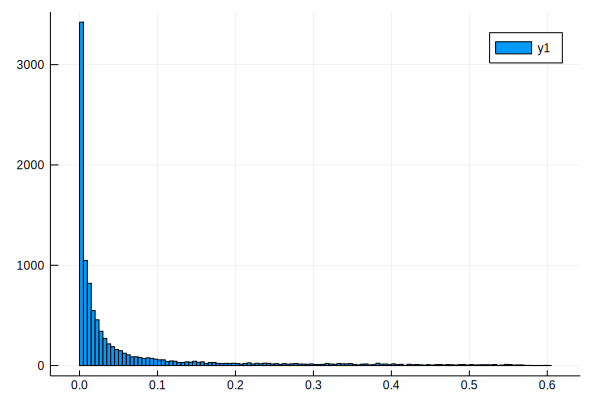

In [159]:
histogram(mOutputs[:, 1])

In [177]:
temp = @time f_mcmc_uniform_harder_target(5000, f_tnf_bimodal, dkdevine, [0.05; 0.05; 0.05; 0.05; 0.01; 0.01; 0.01; 0.01; 0.01], [2, 2, 2], [1, 2, 4], tspan, f_solve, deriv_tnf_signalling, mBounds, initial);

 51.963556 seconds (5.06 M allocations: 345.402 MiB, 0.17% gc time)


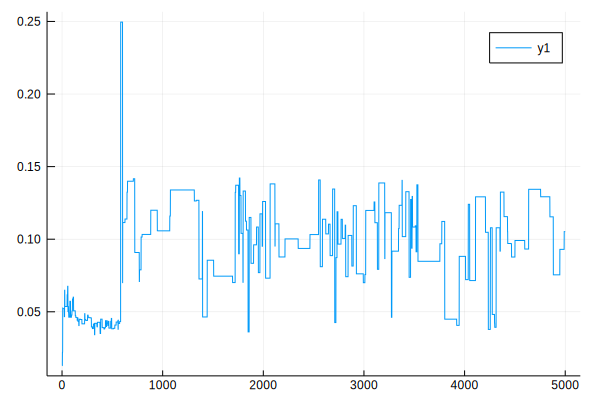

In [181]:
plot(temp["outputs"][:, 3])